In [ ]:
import cv2
import torch
import numpy as np
import os
import sys
sys.path.append('./SuperGluePretrainedNetwork')
from models.matching import Matching
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

# 📐 ChArUco 보드 정의
squares_x, squares_y = 13, 9
square_length = 0.02  # meters
marker_length = 0.01  # meters
dict_type = cv2.aruco.DICT_5X5_100
aruco_dict = cv2.aruco.getPredefinedDictionary(dict_type)
board = cv2.aruco.CharucoBoard(
    (squares_x, squares_y),
    square_length,
    marker_length,
    aruco_dict
)

def load_images(folder):
    return sorted(
        [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.jpeg')],
        key=lambda x: int(os.path.splitext(os.path.basename(x))[0]),
        # reverse=True
    )
# 🔧 SuperGlue 매칭기 초기화
matching = Matching({
    'superpoint': {'nms_radius': 4, 'keypoint_threshold': 0.005, 'max_keypoints': 1024},
    'superglue': {'weights': 'indoor'},
    'sinkhorn_iterations': 20,
    'match_threshold': 0.2,
}).eval().to(device)

def estimate_pose(charuco_corners, charuco_ids, board, K, dist):
    """
    각 charuco 코너의 ID에 맞춰 해당하는 3D 보드 좌표를 수동 계산한 뒤,
    이미지 코너들과 매칭시켜 solvePnP 수행
    """
    obj_pts = []
    img_pts = []

    squares_x, squares_y = board.getChessboardSize()
    square_length = board.getSquareLength()

    for i in range(len(charuco_ids)):
        id = int(charuco_ids[i][0])
        row = id // (squares_x - 1)
        col = id % (squares_x - 1)

        # 3D board 상 위치 (Z=0 평면)
        obj_pts.append([col * square_length, row * square_length, 0.0])
        img_pts.append(charuco_corners[i][0])  # 2D 이미지 좌표

    if len(obj_pts) < 4:
        return False, None, None

    obj_pts = np.array(obj_pts, dtype=np.float32)
    img_pts = np.array(img_pts, dtype=np.float32)

    success, rvec, tvec = cv2.solvePnP(obj_pts, img_pts, K, dist)
    return success, rvec, tvec

# 📊 시각화
def plot_camera_views(poses):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # 🔴 1. 체커보드 그리기 (Z=0 평면)
    squares_x, squares_y = 13, 9
    square_length = 0.02  # meters

    board_corners = np.array([
        [0, 0, 0],
        [(squares_x - 1) * square_length, 0, 0],
        [(squares_x - 1) * square_length, (squares_y - 1) * square_length, 0],
        [0, (squares_y - 1) * square_length, 0]
    ])
    # 보드 외곽선
    for i in range(4):
        p1 = board_corners[i]
        p2 = board_corners[(i + 1) % 4]
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], color='k', linewidth=2)

    # 보드 내 코너 점들도 점으로 표시 (선택적)
    for y in range(squares_y - 1):
        for x in range(squares_x - 1):
            cx = x * square_length
            cy = y * square_length
            ax.scatter(cx, cy, 0, c='k', s=5)

    # 🔵 2. 카메라 위치 시각화
    for idx, (R, t) in enumerate(poses):
        cam_center = (-R.T @ t).reshape(-1)
        x, y, z = cam_center
        ax.scatter(x, y, z, c='r')
        ax.text(x, y, z, f'Cam {idx+1}', size=8)

    # 축 범위
    ax.set_xlim(-0.2, 0.2)
    ax.set_ylim(0.05, 0.2)
    ax.set_zlim(-0.5, 0.0)
    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")
    ax.set_zlabel("Z (m)")
    ax.set_title("Camera Poses with ChArUco Board")
    plt.show()

# === 실행 ===
image_paths = load_images('./camera_images3')
size = 1024
scale = size / 2992  # ≈ 0.3423

K = np.array([
    [1500 * scale,        0, 2992/2 * scale],
    [       0,      1500 * scale, 2992/2 * scale],
    [       0,             0,               1   ]
], dtype=np.float32)
dist = np.zeros((5, 1))

poses = []

# 🔹 첫 이미지 → 기준
ref_img = cv2.imread(image_paths[0], cv2.IMREAD_GRAYSCALE)
ref_img = cv2.resize(ref_img, (size, size))
ref_tensor = torch.from_numpy(ref_img / 255.).float()[None, None].to(device)

# 기준 이미지에서 ChArUco 추출
corners0, ids0, _ = cv2.aruco.detectMarkers(ref_img, aruco_dict)
if ids0 is not None and len(corners0) > 0:
    _, charuco_corners0, charuco_ids0 = cv2.aruco.interpolateCornersCharuco(corners0, ids0, ref_img, board)
    if charuco_corners0 is not None and charuco_ids0 is not None and len(charuco_ids0) >= 4:
        success, rvec0, tvec0 = estimate_pose(charuco_corners0, charuco_ids0, board, K, dist)
        if success:
            R0, _ = cv2.Rodrigues(rvec0)
            poses.append((R0, tvec0))

# 🔄 나머지 이미지들
for i in tqdm(range(1, len(image_paths))):
    img = cv2.imread(image_paths[i], cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (size, size))
    tensor = torch.from_numpy(img / 255.).float()[None, None].to(device)

    # SuperGlue 매칭 (기준 ref vs 현재 이미지)
    inp = {'image0': ref_tensor, 'image1': tensor}
    pred = matching(inp)

    # 결과 추출
    kpts0 = pred['keypoints0'][0].cpu().numpy()
    kpts1 = pred['keypoints1'][0].cpu().numpy()
    matches = pred['matches0'][0].cpu().numpy()

    valid = matches > -1
    matched_kpts0 = kpts0[valid]
    matched_kpts1 = kpts1[matches[valid]]

    # 현재 이미지에서 ChArUco 추출
    corners, ids, _ = cv2.aruco.detectMarkers(img, aruco_dict)
    if ids is not None and len(corners) > 0:
        _, charuco_corners, charuco_ids = cv2.aruco.interpolateCornersCharuco(corners, ids, img, board)
        if charuco_corners is not None and charuco_ids is not None and len(charuco_ids) >= 4:
            success, rvec, tvec = estimate_pose(charuco_corners, charuco_ids, board, K, dist)
            if success:
                R, _ = cv2.Rodrigues(rvec)
                poses.append((R, tvec))

# 📊 모든 pose 시각화
plot_camera_views(poses)

In [ ]:
import cv2
import torch
import numpy as np
import os
import sys
sys.path.append('./SuperGluePretrainedNetwork')
from models.matching import Matching
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

# 📐 ChArUco 보드 정의
squares_x, squares_y = 13, 9
square_length = 0.02
marker_length = 0.01
dict_type = cv2.aruco.DICT_5X5_100
aruco_dict = cv2.aruco.getPredefinedDictionary(dict_type)
board = cv2.aruco.CharucoBoard((squares_x, squares_y), square_length, marker_length, aruco_dict)

def load_images(folder):
    return sorted(
        [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.jpeg')],
        key=lambda x: int(os.path.splitext(os.path.basename(x))[0])
    )

matching = Matching({
    'superpoint': {'nms_radius': 4, 'keypoint_threshold': 0.005, 'max_keypoints': 1024},
    'superglue': {'weights': 'indoor'},
    'sinkhorn_iterations': 20,
    'match_threshold': 0.2,
}).eval().to(device)

def estimate_pose(charuco_corners, charuco_ids, board, K, dist):
    obj_pts, img_pts = [], []
    sx, sy = board.getChessboardSize()
    sl = board.getSquareLength()
    for i in range(len(charuco_ids)):
        id = int(charuco_ids[i][0])
        row, col = id // (sx - 1), id % (sx - 1)
        obj_pts.append([col * sl, row * sl, 0.0])
        img_pts.append(charuco_corners[i][0])
    if len(obj_pts) < 4:
        return False, None, None
    obj_pts = np.array(obj_pts, dtype=np.float32)
    img_pts = np.array(img_pts, dtype=np.float32)
    return cv2.solvePnP(obj_pts, img_pts, K, dist)

def plot_camera_views(poses, K):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    # 보드 그리기
    for y in range(squares_y - 1):
        for x in range(squares_x - 1):
            cx = x * square_length
            cy = y * square_length
            ax.scatter(cx, cy, 0, c='k', s=5)
    for i in range(4):
        corners = [
            [0, 0, 0],
            [(squares_x - 1) * square_length, 0, 0],
            [(squares_x - 1) * square_length, (squares_y - 1) * square_length, 0],
            [0, (squares_y - 1) * square_length, 0]
        ]
        p1, p2 = corners[i], corners[(i + 1) % 4]
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], color='k', linewidth=2)

    fx, fy = K[0, 0], K[1, 1]
    cx, cy = K[0, 2], K[1, 2]
    img_w, img_h = 1024, 1024
    z = -0.01
    scale_factor = 2

    for idx, (R, t) in enumerate(poses):
        cam_center = (-R.T @ t).reshape(-1)
        x, y, zc = cam_center
        ax.scatter(x, y, zc, c='r')
        ax.text(x, y, zc, f'Cam {idx+1}', size=8)
        img_corners = np.array([[0, 0], [img_w, 0], [img_w, img_h], [0, img_h]])
        frustum_pts = []
        for u, v in img_corners:
            x_cam = (u - cx) * z / fx * scale_factor
            y_cam = (v - cy) * z / fy * scale_factor
            frustum_pts.append([x_cam, y_cam, z])
        frustum_pts = (R @ np.array(frustum_pts).T + t).T
        for pt in frustum_pts:
            ax.plot([x, pt[0]], [y, pt[1]], [zc, pt[2]], color='b', linewidth=1)
        for j in range(4):
            p1, p2 = frustum_pts[j], frustum_pts[(j + 1) % 4]
            ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], color='gray', linestyle='--', linewidth=0.8)

    ax.set_xlim(-0.2, 0.2)
    ax.set_ylim(0.05, 0.2)
    ax.set_zlim(-0.5, 0.0)
    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")
    ax.set_zlabel("Z (m)")
    ax.set_title("Camera Poses + ChArUco Board + Frustums")
    plt.show()

def draw_matches(img0, img1, pts0, pts1):
    img0_color = cv2.cvtColor(img0, cv2.COLOR_GRAY2BGR)
    img1_color = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    canvas = np.hstack([img0_color, img1_color])
    offset = img0.shape[1]
    for p0, p1 in zip(pts0, pts1):
        p0 = tuple(np.round(p0).astype(int))
        p1 = tuple(np.round(p1).astype(int) + np.array([offset, 0]))
        cv2.line(canvas, p0, p1, (0, 255, 0), 1)
        cv2.circle(canvas, p0, 2, (255, 0, 0), -1)
        cv2.circle(canvas, p1, 2, (0, 0, 255), -1)
    return canvas

# === 실행 ===
image_paths = load_images('./camera_images3')
size = 1024
scale = size / 2992
K = np.array([[1500 * scale, 0, 2992/2 * scale],
              [0, 1500 * scale, 2992/2 * scale],
              [0, 0, 1]], dtype=np.float32)
dist = np.zeros((5, 1))
poses, homographies = [], []

ref_img = cv2.imread(image_paths[0], cv2.IMREAD_GRAYSCALE)
ref_img = cv2.resize(ref_img, (size, size))
ref_tensor = torch.from_numpy(ref_img / 255.).float()[None, None].to(device)

corners0, ids0, _ = cv2.aruco.detectMarkers(ref_img, aruco_dict)
if ids0 is not None:
    _, charuco_corners0, charuco_ids0 = cv2.aruco.interpolateCornersCharuco(corners0, ids0, ref_img, board)
    if charuco_corners0 is not None and len(charuco_ids0) >= 4:
        success, rvec0, tvec0 = estimate_pose(charuco_corners0, charuco_ids0, board, K, dist)
        if success:
            R0, _ = cv2.Rodrigues(rvec0)
            poses.append((R0, tvec0))

for i in tqdm(range(1, len(image_paths))):
    img = cv2.imread(image_paths[i], cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (size, size))
    tensor = torch.from_numpy(img / 255.).float()[None, None].to(device)

    inp = {'image0': ref_tensor, 'image1': tensor}
    pred = matching(inp)
    kpts0 = pred['keypoints0'][0].cpu().numpy()
    kpts1 = pred['keypoints1'][0].cpu().numpy()
    matches = pred['matches0'][0].cpu().numpy()
    valid = matches > -1
    matched_kpts0 = kpts0[valid]
    matched_kpts1 = kpts1[matches[valid]]

    # ✅ Matching 시각화
    vis = draw_matches(ref_img, img, matched_kpts0, matched_kpts1)
    plt.figure(figsize=(12, 6))
    plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    plt.title(f'Matching {i}')
    plt.axis('off')
    plt.show()

    # ✅ Homography 추정
    if len(matched_kpts0) >= 4:
        H, _ = cv2.findHomography(matched_kpts0, matched_kpts1, cv2.RANSAC, 5.0)
        if H is not None:
            homographies.append(H)
            if len(homographies) <= 5:
                print(f"\n📐 Homography {i}:\n{H}")

    corners, ids, _ = cv2.aruco.detectMarkers(img, aruco_dict)
    if ids is not None:
        _, charuco_corners, charuco_ids = cv2.aruco.interpolateCornersCharuco(corners, ids, img, board)
        if charuco_corners is not None and len(charuco_ids) >= 4:
            success, rvec, tvec = estimate_pose(charuco_corners, charuco_ids, board, K, dist)
            if success:
                R, _ = cv2.Rodrigues(rvec)
                poses.append((R, tvec))

cv2.destroyAllWindows()
plot_camera_views(poses, K)

Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)


100%|██████████| 14/14 [00:01<00:00,  7.75it/s]


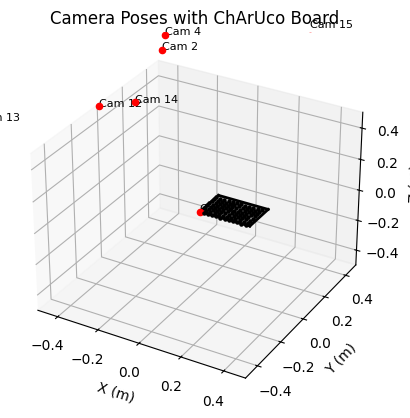

In [ ]:
import cv2
import torch
import numpy as np
import os
import sys
sys.path.append('./SuperGluePretrainedNetwork')
from models.matching import Matching
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

# 📐 ChArUco 보드 정의
squares_x, squares_y = 13, 9
square_length = 0.02  # meters
marker_length = 0.01  # meters
dict_type = cv2.aruco.DICT_5X5_100
aruco_dict = cv2.aruco.getPredefinedDictionary(dict_type)
board = cv2.aruco.CharucoBoard(
    (squares_x, squares_y),
    square_length,
    marker_length,
    aruco_dict
)

def load_images(folder):
    return sorted(
        [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.jpeg')],
        key=lambda x: int(os.path.splitext(os.path.basename(x))[0]),
        # reverse=True
    )
# 🔧 SuperGlue 매칭기 초기화
matching = Matching({
    'superpoint': {'nms_radius': 4, 'keypoint_threshold': 0.005, 'max_keypoints': 1024},
    'superglue': {'weights': 'indoor'},
    'sinkhorn_iterations': 20,
    'match_threshold': 0.2,
}).eval().to(device)

def estimate_pose(charuco_corners, charuco_ids, board, K, dist):
    """
    각 charuco 코너의 ID에 맞춰 해당하는 3D 보드 좌표를 수동 계산한 뒤,
    이미지 코너들과 매칭시켜 solvePnP 수행
    """
    obj_pts = []
    img_pts = []

    squares_x, squares_y = board.getChessboardSize()
    square_length = board.getSquareLength()

    for i in range(len(charuco_ids)):
        id = int(charuco_ids[i][0])
        row = id // (squares_x - 1)
        col = id % (squares_x - 1)

        # 3D board 상 위치 (Z=0 평면)
        obj_pts.append([col * square_length, row * square_length, 0.0])
        img_pts.append(charuco_corners[i][0])  # 2D 이미지 좌표

    if len(obj_pts) < 4:
        return False, None, None

    obj_pts = np.array(obj_pts, dtype=np.float32)
    img_pts = np.array(img_pts, dtype=np.float32)

    success, rvec, tvec = cv2.solvePnP(obj_pts, img_pts, K, dist)
    return success, rvec, tvec

# 📊 시각화
def plot_camera_views(poses):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # 🔴 1. 체커보드 그리기 (Z=0 평면)
    squares_x, squares_y = 13, 9
    square_length = 0.02  # meters

    board_corners = np.array([
        [0, 0, 0],
        [(squares_x - 1) * square_length, 0, 0],
        [(squares_x - 1) * square_length, (squares_y - 1) * square_length, 0],
        [0, (squares_y - 1) * square_length, 0]
    ])
    # 보드 외곽선
    for i in range(4):
        p1 = board_corners[i]
        p2 = board_corners[(i + 1) % 4]
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], color='k', linewidth=2)

    # 보드 내 코너 점들도 점으로 표시 (선택적)
    for y in range(squares_y - 1):
        for x in range(squares_x - 1):
            cx = x * square_length
            cy = y * square_length
            ax.scatter(cx, cy, 0, c='k', s=5)

    # 🔵 2. 카메라 위치 시각화
    for idx, (R, t) in enumerate(poses):
        cam_center = (-R.T @ t).reshape(-1)
        x, y, z = cam_center
        ax.scatter(x, y, z, c='r')
        ax.text(x, y, z, f'Cam {idx+1}', size=8)

    # 축 범위
    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(-0.5, 0.5)
    ax.set_zlim(-0.5, 0.5)
    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")
    ax.set_zlabel("Z (m)")
    ax.set_title("Camera Poses with ChArUco Board")
    plt.show()

# === 실행 ===
image_paths = load_images('./camera_images3')
size = 1024
scale = size / 2992

K = np.array([
    [1500 * scale, 0, 2992 / 2 * scale],
    [0, 1500 * scale, 2992 / 2 * scale],
    [0, 0, 1]
], dtype=np.float32)
dist = np.zeros((5, 1))

poses = [ (np.eye(3), np.zeros((3, 1))) ]  # 첫 이미지 pose: [I|0]

ref_img = cv2.imread(image_paths[0], cv2.IMREAD_GRAYSCALE)
ref_img = cv2.resize(ref_img, (size, size))
ref_tensor = torch.from_numpy(ref_img / 255.).float()[None, None].to(device)

for i in tqdm(range(1, len(image_paths))):
    img = cv2.imread(image_paths[i], cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (size, size))
    tensor = torch.from_numpy(img / 255.).float()[None, None].to(device)

    inp = {'image0': ref_tensor, 'image1': tensor}
    pred = matching(inp)
    kpts0 = pred['keypoints0'][0].cpu().numpy()
    kpts1 = pred['keypoints1'][0].cpu().numpy()
    matches = pred['matches0'][0].cpu().numpy()

    valid = matches > -1
    matched_kpts0 = kpts0[valid]
    matched_kpts1 = kpts1[matches[valid]]

    if len(matched_kpts0) >= 8:
        # 1. Essential Matrix
        E, mask = cv2.findEssentialMat(matched_kpts0, matched_kpts1, K, method=cv2.RANSAC, prob=0.999, threshold=1.0)
        if E is None or E.shape != (3, 3):
            print(f"⚠️ Essential matrix estimation failed at image {i}")
            continue

        # 2. Recover relative pose
        _, R, t, mask_pose = cv2.recoverPose(E, matched_kpts0, matched_kpts1, K)

        # 3. Compose with previous pose
        R_prev, t_prev = poses[-1]
        R_new = R @ R_prev
        t_new = R @ t_prev + t
        poses.append((R_new, t_new))

    # 다음 기준 이미지로 갱신
    ref_img = img.copy()
    ref_tensor = tensor.clone()

# 📊 모든 pose 시각화
plot_camera_views(poses)